**Fundamentals of Solar Cells and Photovoltaic Systems Engineering**

**Solutions Manual - Chapter 2**

**Problem 2.15**


***Estimate the global irradiance G(α,β) reaching the plane of array (POA) of a north-facing, 20° tilted generator over grass (reflectivity=0.2) located at a PV plant in Antananarivo, Madagascar (18° 56′ 0″ S, 47° 31′ 0″ E) at midday (true solar time) on May 12, 2022.***

***Solve the problem using pvlib-python and the default clear-sky model.***

We will use the packages [pvlib](https://pvlib-python.readthedocs.io/en/stable/), [pandas](https://pandas.pydata.org/) and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results.


In [1]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt

We start by defining the location, date and time. 
We will implement the calculation for every hour on May 12, 2022. 

In [3]:
# Antananarivo, Madagascar
lat, lon = -18.93, 47.52
tz = 'Indian/Antananarivo' #existing timezones can be checked using pytz.all_timezones[::20]

date = '2022-05-12'

# surface angles beta, alpha
tilt, orientation = 20, 0 # pvlib sets orientation origin at North -> North=0

# location
location = pvlib.location.Location(lat, lon, tz=tz)

# albedo
albedo = 0.20 # grass reflectivity

# datetimes
times = pd.date_range(start=date, freq='1H', periods=24, tz=tz)

We calculate the clear-sky irradiance using the default options in pvlib. 

In [4]:
# generates clear-sky ghi, dni, dhi irradiances (decomposition using Ineichen model and turbidity index; pvlib's default)
clearsky = location.get_clearsky(times, model='ineichen')

We calculate the Sun's coordinates and calculate the irradiance on the plane of array (POA)

In [6]:
# calculates Sun's coordinates
solar_position = location.get_solarposition(times=times)

# calculates POA (transposition using isotropic model)
poa_fixed_irradiance = pvlib.irradiance.get_total_irradiance(
                        surface_tilt=tilt,
                        surface_azimuth=orientation,
                        dni=clearsky['dni'],
                        ghi=clearsky['ghi'],
                        dhi=clearsky['dhi'],
                        albedo=albedo,
                        solar_zenith=solar_position['apparent_zenith'],
                        solar_azimuth=solar_position['azimuth'],
                        model='isotropic')

We can plot the daily evolution of direct, diffuse, and global irradiance

Text(0, 0.5, 'Irradiance [$W/m^2$]')

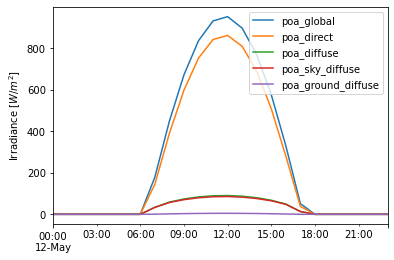

In [7]:
poa_fixed_irradiance.plot()
plt.ylabel('Irradiance [$W/m^2$]')

And obtain the value at midday. 

In [8]:
poa_fixed_irradiance.loc['2022-05-12 12:00']

poa_global            951.649954
poa_direct            861.213729
poa_diffuse            90.436225
poa_sky_diffuse        85.570772
poa_ground_diffuse      4.865453
Name: 2022-05-12 12:00:00+03:00, dtype: float64

We can also obtain the values at any other time step.

In [7]:
poa_fixed_irradiance

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2022-05-12 00:00:00+03:00,0.000000,0.000000,0.000000,0.000000,0.000000
2022-05-12 01:00:00+03:00,0.000000,0.000000,0.000000,0.000000,0.000000
2022-05-12 02:00:00+03:00,0.000000,0.000000,0.000000,0.000000,0.000000
2022-05-12 03:00:00+03:00,0.000000,0.000000,0.000000,0.000000,0.000000
2022-05-12 04:00:00+03:00,0.000000,0.000000,0.000000,0.000000,0.000000
2022-05-12 05:00:00+03:00,0.000000,0.000000,0.000000,0.000000,0.000000
2022-05-12 06:00:00+03:00,0.000000,0.000000,0.000000,0.000000,0.000000
2022-05-12 07:00:00+03:00,178.552469,144.682689,33.869780,33.139604,0.730176
2022-05-12 08:00:00+03:00,448.361907,389.462201,58.899706,56.795933,2.103773
2022-05-12 09:00:00+03:00,671.502597,597.574027,73.928571,70.614999,3.313572
